# Feature Selection and Random Forests.

In prediction tasks, given data does not necessary consist of only important information. The data may contain irrelevant features, which impairs the performance of a predictor due to overfitting. This situation is the case for medical data. While we have thousands of features, only a few hundreds samples are available. In this case, we have to extract only effective features and get rid of unnecessary ones. In this article, we work on [“Dorothea Data Set” from UCL Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Dorothea). This is data for binary classification with 10000 features. Reducing feature dimension is the key to have better predictor.

# 1. Background

Random forests has been introduced by Breiman in [the paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) in 2001. He proposed collecting many classification and regression trees(CART) and used them to establish better predictors. The key concept of random forests is bagging introduced by Breiman in [the paper](rhttp://statistics.berkeley.edu/sites/default/files/tech-reports/421.pdf) in 1994. The name comes from the combination of acronym of two words: bootstrap and aggregating. Bagging has been succeeded to improve unstable predictors like neural network and CART. By applying bagging to CART, we obtain the better accuracy tree, random forests. As one of the useful byproducts, we can use random forests to measure importance of each input feature.  We explain these concepts in the following order: bootstrap, bagging, and random forests.

## 1.1. Bootstrap

Bootstrap is a general methodology to measure the accuracy of estimations based on resampling, which has been introduced by Efron and Tibshirani in [the paper](https://projecteuclid.org/download/pdf_1/euclid.ss/1177013815). Since the variance of an estimation is frequently used to measure the accuracy of estimation, bootstrap is practically used to guess the variance of the estimation. Especially, bootstrap gives us a computational approach to analytically intractable cases.  

Let's say we have $n$ samples from distribution $F$ and estimate its mean with the unbiased estimator,
$$ \bar{x} = \sum_{i=1}^n x_i / n.$$
Let us denote by $\mu_2 (F) = E_F X^2 - (E_F X)^2$  the variance of distribution $F$. We analytically calculate the standard deviation $\sigma(F; N, \bar{x})$ as
$$\sigma (F) = [\mu_2 (F) / n]^{1/2},$$
where $\sigma(F) \equiv \sigma(F; n, \bar{x})$. Since $\mu_2 (F) $ is unknown function, we use unbiased estimator  $\bar{\mu}_2 = \sum_{i=1}^n (x_i - \bar{x})^2 / (n - 1)$ instead; i.e., we have
$$\bar{\sigma} = [\bar{\mu}_2 / n]^{1/2}.$$

There is another way. Let $\hat{F}$ be the empirical distribution; i.e., $\hat{F}$ assigns the probability mass $1/n$ to each data point $x_i$. Then, we obtain
$$\bar{\sigma} \equiv \sigma(\hat{F}) = [\mu_2(\hat{F}) / n]^{1/2},$$
where $\mu_2(\hat{F}) = \sum_{i=1}^n (x_i - \bar{x})^2 / n$. This approach is more flexible. In the above mean estimation example, we have to know the analytical expression of unbiased estimation of the variance, which is not often the case for more complex estimations. 

To apply the second method to even more complex cases, we introduce the new sampling concept called bootstrap sampling. Let us assume that we estimate $\theta$, which corresponds to $E_F X$ in the previous example. To formalize into the second method, we need to calculate
$$E_{\hat{F}} (\hat{{\theta}}(\bf{x}) - E_{\hat{F}} \hat{{\theta}}(\bf{x}))^2,$$
where $\hat{F}$ is the empirical distribution of n data points $\bf{x} = (x_1, x_2, \dots, x_n)$. Since computing all of the case $\hat{{\theta}}(\bf{x})$ is too expensive, we resort to Monte Carlo method; i.e., we take sample mean with B sets of data $\{\bf{x}^b\}_{b=1}^B = \{x_1^b, x_2^b, \dots, x_n^b\}_{b=1}^B$ sampled from empirical distribution $\hat{F}$. Note that all of sets must have exactly n data because the expression of estimation depends on n. This sampling method is called bootstrap sampling. Taking sample mean instead of expectation leads to
$$\theta^*(\cdot) = \frac{\sum_{b=1}^B \hat{\theta }(b)}{B}$$
$$\sigma_B = \left(\frac{\sum_{b=1}^B (\hat{\theta}(b) - \theta^*(\cdot) }{B - 1}\right)^{1/2}.$$
$\sigma_B$ can be used to measure the accuracy of the estimation.

For more precise discussion over the accuracy of this method itself, you can check [the original paper](https://projecteuclid.org/download/pdf_1/euclid.ss/1177013815).

## 1.2. Bagging

Bagging has been introduced by Breiman in [the paper](rhttp://statistics.berkeley.edu/sites/default/files/tech-reports/421.pdf). He used bootstrap sampling to improve the accuracy of unstable predictors. The concept is quite simple. Consider a predictor trained by training set $\mathcal{L}$. For each input $x$, prediction can be expressed as $\varphi(x, \mathcal{L})$. For regression case, we can define the aggregated predictor as 
$$\varphi_A(x) = E_{\mathcal{L}} \varphi(x, \mathcal{L}).$$

For the classification case, the class voted by the most predictors would be the prediction value. That is, each $\varphi(x, \mathcal{L})$ has C dimensional output $\varphi(x, \mathcal{L}) = (\varphi^1(x, \mathcal{L}), \varphi^2(x, \mathcal{L}), \dots, \varphi^C(x, \mathcal{L}))$ and each component corresponds to each class confidence. Then, the aggregated predictor is defined as 
$$\varphi_A(x) = \underset{1 \leq c \leq C}{max} E_{\mathcal{L}} \varphi^c(x, \mathcal{L}).$$

This aggregation procedure especially increase the accuracy of unstable predictors. Consider the regression case. We have the generalized prediction error in $\varphi (x, \mathcal{L})$ and $\varphi_A(x)$:
$$e = E_{\mathcal{L}} E_{y, x} (y - \varphi(x, \mathcal{L}))^2,$$
$$e_A = E_{y, x} (y - \varphi_A(x))^2.$$
Then, we obtain
$$e = E_{\mathcal{L}} E_{y, x} y^2 - 2 E_{y, x}y \varphi_A(x) +  E_{\mathcal{L}} E_{y, x} \varphi(x, \mathcal{L})^2\\
\geq E_{y, x} (y - \varphi_A(x))^2\\
= e_A,$$
where we use Jensen inequality, $E_{\mathcal{L}}\varphi(x, \mathcal{L})^2 \geq (E_{\mathcal{L}}\varphi(x, \mathcal{L}))^2$. Hence, aggregated predictor has better performance if and only if $E_{\mathcal{L}}\varphi(x, \mathcal{L})^2$ is strictly greater than $(E_{\mathcal{L}}\varphi(x, \mathcal{L}))^2$, which implies that unstable predictors — large variance predictors — will be improved by the aggregation. 

In the practical situation, the calculation of $E_{\mathcal{L}} \varphi(x, \mathcal{L})$ is often intractable. Then, we often use 
$$\varphi_B(x) = \hat{E}_{\mathcal{L}} \varphi(x, \mathcal{L}),$$
where $\hat{E}(\cdot)$ is empirical expectation calculated through bootstrap sampling. Bootstrap sampling gives us some numerical errors between $\varphi_B(x)$ and $\varphi_A(x)$. Therefore, there is cross-over point between instability and stability at which $\varphi_B(x)$ stop improving and does worse. Indeed, there is the example that stability predictor does worse through bagging in [the paper](rhttp://statistics.berkeley.edu/sites/default/files/tech-reports/421.pdf).

In classification, a predictor predicts a class label $c \in \{1, 2, \dots, C\}$. The probability of correct classification can be calculated as 
$$r(\mathcal{L}) = \sum_{c} P(\varphi(x, \mathcal{L}) = c | y = c) P(y = c).$$
We define $Q(c | x) \equiv P_{\mathcal{L}}(\varphi(x, \mathcal{L}) = c)$, where$P_{\mathcal{L}}$ is probability measure of samples $\mathcal{L}$. By taking marginalization over $P_\mathcal{L}$, we have
$$r = \sum_{c}E[Q(c | x) | y=c] P(y = c)\\
= \sum_{c} \int Q(c | x) P(y=c|x) P_x(dx).$$

Since the aggregated predictor is equivalent to $\varphi_A(x) = \underset{c}{argmax} Q(c | x)$, we can write down the probability of correct classification of the aggregated predictor as
$$r_A = \sum_{c} \int I(\underset{j}{argmax} Q(j | x) = c) P(y=c|x) P_x(dx),$$
where $I(\cdot)$ is the indicator function. Consider a set $D$,
$$D = \{x; \underset{c}{argmax} Q(c | x) = \underset{c}{argmax} P(c | x) \}.$$
We can express $r_A$ as 
$$r_A = \int_D \underset{c}{max}P(y=c|x) P_x(dx) + \sum_{c} \int_{D^c} I(\varphi_A(x) = c) P(y=c|x) P_x(dx).$$

For each predictor, the highest attainable correct prediction is obtained when $P_x(D) = 1$; i.e., we have
$$r^* = \int \underset{c}{max}P(y=c|x) P_x(dx).$$
For $x \in D$, $\sum_{c} Q(c | x) P(y = c | x)$ can be less than $\underset{c}{max}P(y=c|x)$. Thus, even if $P_x(D) \simeq 1$, non-aggregated predictor might be far from optimal. 

In classification, aggregation actually improves the performance more for the better performance predictor. This can be deduced from the above expression of $r_A$. In order to have the performance close to optimal one $r^*$, we have to assign large probability mass to $D$; i.e., the predictor already have high probability of correct classification. As to the stability of the predictor, the same statement as regression holds for classification. 

## 1.3. Random Forests and Feature Importance

Random forest has been introduced by Breiman in [the paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) . As we discussed previously, bagging improves the accuracy of unstable predictors like neural network and CART. Then, He applied bagging to CART to improve the accuracy.

Concept is quite simple. At every node, we just split data depending on subset of variable. Let's say we have $M$ dimensional input feature. At every node, randomly chosen subset $s$ variables  of $M$ variables are used to split data. After established some trees, we mean of outputs of trees for regression, or 
take vote as to which class will data should be classified for classification. 

As one of the useful byproducts of bootstrap sampling, we have unused samples called out-of-bags, which has been discussed in [the paper](https://www.stat.berkeley.edu/~breiman/OOBestimation.pdf)  by Breiman. When using bootstrap sampling, we have unsampled data for each set. This comes from the following:

Let $N$ be the number of data. The probability to unsample one of the data $x_i$ is $(1 - \frac{1}{N})^N$. By using the fact that $\underset{n\to \infty}{lim}(1 + \frac{1}{N})^{-N} = \frac{1}{e}$, we can lead to $\underset{N \to \infty}{lim}(1 - \frac{1}{N})^N = \frac{1}{e} \simeq 0.3679$. Thus, for large enough data, almost 37% data will not be sampled. Using these unsampled data, we can improve accuracy of prediction for important some statistical quantities. For example, it is known that training error has downside bias. We can use out-of-bag to have more accurate estimation of generalized error without any additional data. Thus, to evaluate the performance of random forests, we need neither of test data nor additional computational time coming from cross validation. 

As another useful byproducts, we have feature importance. This is a quantity to measure the importance of each component of input for prediction. As we mentioned above, the performance of random forest is measured on out-of-bag. The performance should be measured by certain criteria such as Gini index, entropy, and accuracy. Then, we add noise to each variables and see how much the value of the criteria changes. We do this through the following process.

Let us assume that we use $M$ dimensional input feature $\bf{x} = (x_1, x_2, \dots, x_M)$ and $N_T$ trees for estimation.

FOR i = 1 to $N_T$
- Generate a tree
- Evaluate performance on out-of-bag

FOR m = 1 to $M$

- Collapse $x_m$ by noise 
- Evaluate and save the change of the value of the criteria

END FOR

END FOR

- Take mean saved changes (The higher, the more important)


Through this process, we identify which component is significant for prediction. In scikit-learn implementation, normalized criteria are used to evaluate the feature importance; they measure how much noised feature increases the value of criteria in the percentage. Gini impurity and mean squared error used as default for classification and regression respectively.

# 2. Experiments

Let's wrok on analysis!!!! 

We use the following libraries.

In [2]:
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn.model_selection import KFold
from six.moves import zip, xrange
from sklearn.preprocessing import Imputer
from tqdm import tqdm
import matplotlib.pyplot as plt

# keras (tensorflow backend)
from keras.layers import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dense
from keras.layers.advanced_activations import PReLU
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import backend as K

%matplotlib inline

We fetch data from the local machine.

In [20]:
f = open("dorothea_train.data")

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

def get_feature(filename, num_feature=100000):
    f = open(filename) 
    data = f.read()
    data = data.splitlines()
    features = np.zeros((len(data), num_feature))
    for i, x in enumerate(data):
        index = np.array(x.split(), dtype=int) - 1
        features[i][index] = 1
    return features

In [91]:
train_input, test_input = get_feature("dorothea_train.data"), get_feature("dorothea_valid.data")

In [92]:
f = open("dorothea_train.labels")
train_target = np.array(f.read().split(), dtype=int)

In [112]:
def get_label(filename):
    f = open(filename)
    labels = np.array(f.read().split(), dtype=int)
    return (labels + 1.) * 0.5

In [113]:
train_target, test_target = get_label("dorothea_train.labels"), get_label("dorothea_valid.labels")

In [114]:
train_target

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0

In [116]:
%%time

forest = RandomForestClassifier(n_estimators=1000)
forest.fit(train_input, train_target)

CPU times: user 38.6 s, sys: 0 ns, total: 38.6 s
Wall time: 38.6 s


In [167]:
print(shuffle_index)

[46602 63818 24173 ...,  8908 64487 55755]


In [165]:
# get idnex of features in descending order of the importance
index = np.argsort(forest.feature_importances_)[::-1]
shuffle_index = index.copy()
np.random.shuffle(shuffle_index)

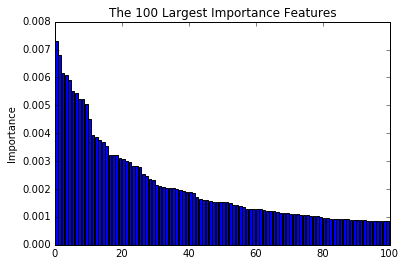

In [131]:
fig, ax = plt.subplots()
ax.set_ylabel('Importance')
ax.set_title('The 100 Largest Importance Features')

num_index = 100
_ = ax.bar(np.arange(num_index), forest.feature_importances_[index[:num_index]])

plt.savefig("100_importance.png")

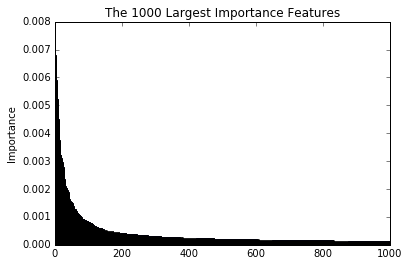

In [136]:
fig, ax = plt.subplots()
ax.set_ylabel('Importance')
ax.set_title('The 1000 Largest Importance Features')

num_index = 1000
_ = ax.bar(np.arange(num_index), forest.feature_importances_[index[:num_index]])
plt.savefig("1000_importance.png")

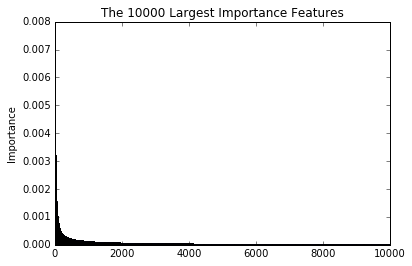

In [137]:
fig, ax = plt.subplots()
ax.set_ylabel('Importance')
ax.set_title('The 10000 Largest Importance Features')

num_index = 10000
_ = ax.bar(np.arange(num_index), forest.feature_importances_[index[:num_index]])
plt.savefig("10000_importance.png")

In [223]:
# the number of features to check the performance
logspace = np.logspace(0, int(np.log10(len(index))), 100)
logspace = [int(x) for x in logspace]

In [224]:
print(logspace)

[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 23, 25, 29, 32, 36, 41, 46, 52, 58, 65, 73, 83, 93, 104, 117, 132, 148, 166, 187, 210, 236, 265, 298, 335, 376, 422, 475, 533, 599, 673, 756, 849, 954, 1072, 1204, 1353, 1519, 1707, 1917, 2154, 2420, 2718, 3053, 3430, 3853, 4328, 4862, 5462, 6135, 6892, 7742, 8697, 9770, 10974, 12328, 13848, 15556, 17475, 19630, 22051, 24770, 27825, 31257, 35111, 39442, 44306, 49770, 55908, 62802, 70548, 79248, 89021, 100000]


In [154]:
def compute_accuracy(y, prediction):
    error = np.abs(prediction - y)
    return 1 - np.mean(error)


In [180]:
from sklearn.metrics import roc_auc_score

def predictor_RFC_score(X_train, X_test, y_train, n_estimators=100, criterion='gini'):
    """Return prediciton of random forests regressor"""
    forest = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
    forest.fit(X_train, y_train)
    return forest.predict_proba(X_test)[:, 1]

def compute_auc_score(y, prediction):
    return roc_auc_score(y, prediction)

In [187]:
from sklearn.linear_model import LogisticRegression

def predictor_linear_score(X_train, X_test, y_train):
    """Return prediciton of random forests regressor"""
    regr = LogisticRegression()
    regr.fit(X_train, y_train)
    return regr.predict_proba(X_test)[:, 1]

In [189]:
predictor_linear_score(train_input, test_input, train_target)

array([  1.61328939e-03,   3.76179325e-03,   3.55369804e-02,
         2.78761647e-03,   1.48074433e-03,   3.20301585e-03,
         3.39544511e-03,   6.20405628e-02,   2.53914560e-03,
         6.39833175e-03,   1.22659669e-02,   4.27198712e-01,
         4.40001137e-04,   2.63738443e-02,   2.30469669e-03,
         2.94281379e-03,   3.93140952e-03,   2.10778330e-03,
         5.53323694e-03,   9.99726113e-03,   1.35395154e-03,
         2.48097462e-03,   2.85024107e-03,   7.02718226e-03,
         3.07532436e-01,   4.95710480e-03,   3.74468313e-03,
         2.00436399e-03,   6.13062697e-03,   2.74916470e-04,
         7.31270434e-03,   6.00468934e-03,   4.68607961e-03,
         8.59231935e-04,   3.46457657e-03,   9.16577379e-03,
         4.89017434e-04,   2.60785547e-05,   7.43368665e-03,
         2.46335288e-03,   3.12635800e-03,   9.55907619e-03,
         3.65565960e-03,   1.62161947e-03,   2.78261896e-03,
         5.16911819e-03,   1.52518993e-03,   3.10282510e-01,
         9.35684413e-03,

In [ ]:
%%time
scores = []
for i in logspace:
    prediction = predictor_RFC_score(train_input[:, index[:i]], test_input[:, index[:i]], train_target)
    scores.append(compute_auc_score(test_target, prediction))

In [ ]:
%%time
shuffle_scores = []
for i in logspace:
    prediction = predictor_RFC_score(train_input[:, shuffle_index[:i]], test_input[:, shuffle_index[:i]], train_target)
    shuffle_scores.append(compute_auc_score(test_target, prediction))

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('score')
ax.set_title('AUC')
ax.set_xscale('log')

ax.plot(logspace, scores, label='importance')
ax.plot(logspace, shuffle_scores, label='shuffle')
ax.legend(loc='lower right')

In [ ]:
%%time

linear_scores = []
for i in logspace:
    prediction = predictor_linear_score(train_input[:, index[:i]], test_input[:, index[:i]], train_target)
    linear_scores.append(compute_auc_score(test_target, prediction))

In [ ]:
%%time

shuffle_linear_scores = []
for i in logspace:
    prediction = predictor_linear_score(train_input[:, shuffle_index[:i]], test_input[:, shuffle_index[:i]], train_target)
    shuffle_linear_scores.append(compute_auc_score(test_target, prediction))

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('score')
ax.set_title('AUC')
ax.set_xscale('log')

ax.plot(logspace, linear_scores, label='importance')
ax.plot(logspace, shuffle_linear_scores, label='shuffle')
ax.legend(loc='lower right')

In [ ]:
plt.plot(scores, label='RF')
plt.plot(shuffle_scores, label='RF_shuffle')
plt.plot(linear_scores, label='linear')
plt.plot(shuffle_linear_scores, label='linear_shuffle')
plt.legend(loc='lower right')

## 2.2. Prediction

In the same way as completion, input feature dimension is large compared to the training set size. Therefore, we consider reducing dimension with importance of feature with random forests. We use the data completed in the previous section.

In [342]:
X = np.concatenate((filled_cont, filled_binary), axis=1)

In [372]:
%%time

forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X, data[2])

CPU times: user 30.2 s, sys: 80 ms, total: 30.2 s
Wall time: 30 s


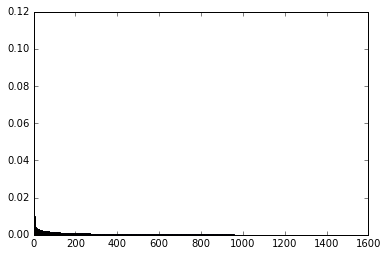

In [373]:
# get idnex of features in descending order of the importance
new_index = np.argsort(forest.feature_importances_)[::-1]
n_data = len(forest.feature_importances_)
_ = plt.bar(np.arange(n_data), forest.feature_importances_[new_index])

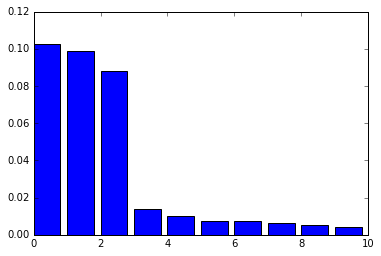

In [374]:
_ = plt.bar(np.arange(10), forest.feature_importances_[new_index[:10]])

In [346]:
print(new_index)

[   2    1    0 ..., 1411  963  569]


It seems that three continuous variables are significant at the prediction stage.

In the same way as the previous section, we compare the features selected based on importance of feature with randomly selected features.

In [365]:
shuffle_index = new_index.copy()
np.random.shuffle(shuffle_index)
print('index oredered by feature importance:')
print(new_index)
print('index permuated at random:')
print(shuffle_index)

index oredered by feature importance:
[   2    1    0 ..., 1411  963  569]
index permuated at random:
[1273 1293  904 ..., 1549 1249 1043]


In [366]:
# the number of features to check the performance
new_logspace = np.logspace(0, int(np.log10(len(new_index))), 10)
new_logspace = [int(x) for x in new_logspace]
new_logspace.append(len(new_index))
new_logspace

[1, 2, 4, 10, 21, 46, 100, 215, 464, 1000, 1558]

We evaluate the algorithms with accuracy rather than error.

In [367]:
def compute_accuracy(y, prediction):
    error = 0.5 * np.abs(prediction - y)
    return 1 - np.mean(error)

def evaluate_predictor(inputs, labels, predictor, *args):
    kf = KFold(n_splits=10)
    accuracies = []
    for idx, (train, test) in enumerate(tqdm(kf.split(inputs))):
        X_train, X_test = inputs[train], inputs[test]
        y_train, y_test = labels[train], labels[test]
        Y = np.concatenate((np.nan * y_test, y_train))
        prediction = predictor(*((X_train, X_test, y_train) + args))
        accuracy = compute_accuracy(y_test, prediction)
        accuracies.append(accuracy)
    return np.mean(accuracies)

### Random Forests

In [463]:
def predictor_RFC(X_train, X_test, y_train, n_estimators=100, criterion='gini'):
    """Return prediciton of random forests regressor"""
    forest = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
    forest.fit(X_train, y_train)
    return forest.predict(X_test)

In [385]:
%%time

accuracies_RF = []
for i in new_logspace:
    accuracies_RF.append(evaluate_predictor(X[:, new_index[:i]], data[2], predictor_RFC, 100))

10it [00:03,  2.65it/s]
10it [00:03,  2.72it/s]
10it [00:04,  2.44it/s]
10it [00:03,  2.62it/s]
10it [00:03,  2.62it/s]
10it [00:04,  2.35it/s]
10it [00:05,  1.88it/s]
10it [00:06,  1.46it/s]
10it [00:10,  1.02s/it]
10it [00:16,  1.69s/it]
10it [00:27,  2.75s/it]

CPU times: user 1min 30s, sys: 240 ms, total: 1min 31s
Wall time: 1min 30s


In [382]:
%%time

shuffle_accuracies_RF = []
for i in new_logspace:
    shuffle_accuracies_RF.append(evaluate_predictor(X[:, shuffle_index[:i]], data[2], predictor_RFC, 100))

10it [00:02,  4.11it/s]
10it [00:02,  4.27it/s]
10it [00:02,  4.23it/s]
10it [00:02,  4.00it/s]
10it [00:02,  3.66it/s]
10it [00:03,  2.88it/s]
10it [00:05,  1.97it/s]
10it [00:07,  1.26it/s]
10it [00:11,  1.17s/it]
10it [00:17,  1.72s/it]
10it [00:27,  2.70s/it]

CPU times: user 1min 25s, sys: 244 ms, total: 1min 25s
Wall time: 1min 24s


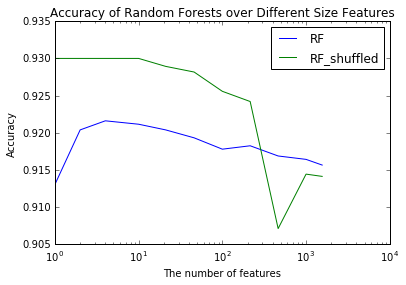

In [386]:
fig, ax = plt.subplots()

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Random Forests over Different Size Features')

ax.plot(new_logspace, accuracies_RF, label='RF', color='b')
ax.plot(new_logspace, shuffle_accuracies_RF, label='RF_shuffled', color='g')
ax.set_xlabel('The number of features')
ax.set_xscale('log')
_ = ax.legend(loc='upper right')

Oops!! What is going on!? Using features selected by importance of feature has worse performance.

In [414]:
np.mean(data[2])

0.13998170173833485

I see. The class distribution is skewed and positive instances occupy only about 14% of entire data. Consider the case where there are 99% negative and 1% positive instances. Even the predictor always return negative achieve 99% accuracy. On the other hand, a predictor that predict classify negative instances with 98% accuracy and positive instances with 99% accuracy achieve 98.01% accuracy as a whole. Does that mean the former predict is better than the latter one? Not necessary!. Sometimes, detecting the class occupying small portion of data is more important; e.g., cancer diagnosis. 

We consider different measures. Let’s consider True Positive Rate(TPR). TPR is the measure as to ratio of positive examples succeeded to detect:
$$ TPR = \frac{TP}{TP + FN},$$
where TP is True Positive and FN is False Positive.

In [422]:
def positive_func(x):
    return 0.5 * (x + np.abs(x))

In [529]:
def compute_TPR(y, prediction):
    n_pos = np.sum(y)
    TPR = (n_pos - np.sum(positive_func(y - prediction))) / n_pos
    return TPR


def evaluate_predictor(inputs, labels, metrics, predictor, *args):
    kf = KFold(n_splits=10)
    accuracies = []
    for idx, (train, test) in enumerate(tqdm(kf.split(inputs))):
        X_train, X_test = inputs[train], inputs[test]
        y_train, y_test = labels[train], labels[test]
        Y = np.concatenate((np.nan * y_test, y_train))
        prediction = predictor(*((X_train, X_test, y_train) + args))
        accuracy = metrics(y_test, prediction)
        accuracies.append(accuracy)
    return np.mean(accuracies)

In [473]:
%%time

accuracies_RF = []
for i in new_logspace:
    accuracies_RF.append(evaluate_predictor(X[:, new_index[:i]], data[2], compute_TPR, predictor_RFC, 100))

10it [00:03,  2.63it/s]
10it [00:03,  2.64it/s]
10it [00:04,  2.41it/s]
10it [00:03,  2.59it/s]
10it [00:03,  2.55it/s]
10it [00:04,  2.34it/s]
10it [00:05,  1.89it/s]
10it [00:06,  1.47it/s]
10it [00:10,  1.02s/it]
10it [00:17,  1.72s/it]
10it [00:27,  2.74s/it]

CPU times: user 1min 31s, sys: 36 ms, total: 1min 31s
Wall time: 1min 30s


In [474]:
%%time

shuffle_accuracies_RF = []
for i in new_logspace:
    shuffle_accuracies_RF.append(evaluate_predictor(X[:, shuffle_index[:i]], data[2], compute_TPR, predictor_RFC, 100))

10it [00:02,  4.26it/s]
10it [00:02,  4.27it/s]
10it [00:02,  4.22it/s]
10it [00:02,  4.04it/s]
10it [00:02,  3.65it/s]
10it [00:03,  2.86it/s]
10it [00:05,  1.95it/s]
10it [00:08,  1.25it/s]
10it [00:11,  1.19s/it]
10it [00:17,  1.74s/it]
10it [00:27,  2.73s/it]

CPU times: user 1min 26s, sys: 72 ms, total: 1min 26s
Wall time: 1min 25s


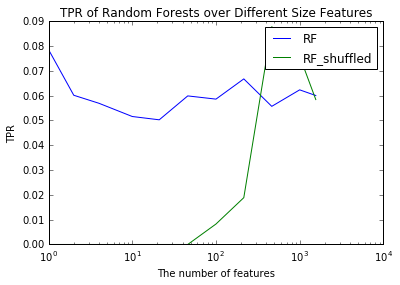

In [475]:
fig, ax = plt.subplots()

ax.set_ylabel('TPR')
ax.set_title('TPR of Random Forests over Different Size Features')

ax.plot(new_logspace, accuracies_RF, label='RF', color='b')
ax.plot(new_logspace, shuffle_accuracies_RF, label='RF_shuffled', color='g')
ax.set_xlabel('The number of features')
ax.set_xscale('log')
_ = ax.legend(loc='upper right')

Random frests with randomly chosen features fails in picking up positive example while RF with selected features detect some.

When working on binary classification task, we usually first have real value output from the predictor and classify data going over certain threshold value into  positive. Mostly, the output is restricted to $[0, 1]$ and threshold is set as 0.5. This setting may work when class is equivalently distributed; i.e., positive 50% and negative 50%. Skewed class distribution, however, cause too little detecting either of them.  This comes from the learning architecture. In most cases, we use non skewed cost function like binary cross entropy in the learning stage. To avoid this, we have to set threshold as a hyper parameter. There is a measure related to this topic called receiver operating characteristic(ROC). Taking TPR and FPR as y-axis and axis respectively, this measure visualize the performance of  a predictor with plot along with various threshold values. This plot is called ROC Curve. The area under this curve in the graph is often used as a measure of the performance of a predictor, which is called the area under an ROC Curve (AUC). We use AUC to evaluate the performance.

In [487]:
from sklearn.metrics import roc_auc_score

def predictor_RFC_score(X_train, X_test, y_train, n_estimators=100, criterion='gini'):
    """Return prediciton of random forests regressor"""
    forest = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
    forest.fit(X_train, y_train)
    return forest.predict_proba(X_test)[:, 1]

def compute_auc_score(y, prediction, ratio):
    return roc_auc_score(y, prediction)

In [494]:
%%time

accuracies_RF = []
for i in new_logspace:
    accuracies_RF.append(evaluate_predictor(X[:, new_index[:i]], data[2], compute_auc_score, predictor_RFC_score, 100))

10it [00:04,  2.37it/s]
10it [00:03,  2.65it/s]
10it [00:04,  2.42it/s]
10it [00:03,  2.61it/s]
10it [00:03,  2.59it/s]
10it [00:04,  2.35it/s]
10it [00:05,  1.90it/s]
10it [00:06,  1.46it/s]
10it [00:10,  1.02s/it]
10it [00:17,  1.72s/it]
10it [00:27,  2.72s/it]

CPU times: user 1min 31s, sys: 80 ms, total: 1min 31s
Wall time: 1min 31s


In [495]:
%%time

shuffle_accuracies_RF = []
for i in new_logspace:
    shuffle_accuracies_RF.append(
        evaluate_predictor(X[:, shuffle_index[:i]], data[2], compute_auc_score, predictor_RFC_score, 100))

10it [00:02,  4.29it/s]
10it [00:02,  4.00it/s]
10it [00:02,  4.22it/s]
10it [00:02,  4.03it/s]
10it [00:02,  3.63it/s]
10it [00:03,  2.81it/s]
10it [00:05,  1.91it/s]
10it [00:08,  1.22it/s]
10it [00:12,  1.25s/it]
10it [00:18,  1.76s/it]
10it [00:28,  2.99s/it]

CPU times: user 1min 28s, sys: 44 ms, total: 1min 28s
Wall time: 1min 28s


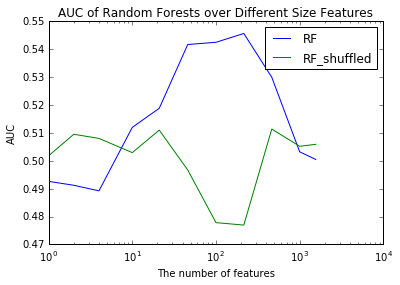

In [532]:
fig, ax = plt.subplots()

ax.set_ylabel('AUC')
ax.set_title('AUC of Random Forests over Different Size Features')

ax.plot(new_logspace, accuracies_RF, label='RF', color='b')
ax.plot(new_logspace, shuffle_accuracies_RF, label='RF_shuffled', color='g')
ax.set_xlabel('The number of features')
ax.set_xscale('log')
_ = ax.legend(loc='upper right')

AUC score reach the maximum around 100 seelcted features. 

In the AUC, TPR and FPR are used as measures of the performance. Since $TNR = 1 - FPR$, we can use TPR and TNR as measures. Then, we use 
$$\sqrt{TPR \times TNR}.$$

In [517]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def predictor_RFC_threshold(X_train, X_test, y_train, threshold=0.5, n_estimators=100, criterion='gini'):
    """Return prediciton of random forests regressor"""
    forest = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
    forest.fit(X_train, y_train)
    score = forest.predict_proba(X_test)[:, 1]
    lb = LabelBinarizer()
    return lb.fit_transform(score >= threshold)[:, 0]
    

def compute_geo_metrics(y, prediction, ratio):
    n_pos = np.sum(y)
    n_neg = len(y) - n_pos
    TPR = (n_pos - np.sum(positive_func(y - prediction))) / n_pos
    TNR = (n_neg - np.sum(positive_func(prediction - y))) / n_neg
    return np.mean(np.sqrt(TPR * TNR))

In [528]:
%%time
thresholds = np.linspace(0, 1, 100)

accuracies_geo = []
for th in thresholds:
    accuracy = evaluate_predictor(X[:, new_index[:100]], data[2], 
                              compute_geo_metrics, predictor_RFC_threshold, th, 100)
    accuracies_geo.append(accuracy)

10it [00:05,  1.83it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.84it/s]
10it [00:05,  1.88it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.78it/s]
10it [00:05,  1.73it/s]
10it [00:05,  1.74it/s]
10it [00:05,  1.77it/s]
10it [00:05,  1.77it/s]
10it [00:05,  1.84it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.80it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.89it/s]
10it [00:05,  1.88it/s]
10it [00:05,  1.85it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.84it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.85it/s]
10it [00:05,  1.84it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.83it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.84it/s]
10it [00:05,  1.87it/s]
10it [00:05,  1.85it/s]
10it [00:05,  1.85it/s]
10it [00:05,  1.89it/s]
10it [00:05,  1.86it/s]
10it [00:05,  1.

CPU times: user 9min, sys: 252 ms, total: 9min 1s
Wall time: 8min 56s


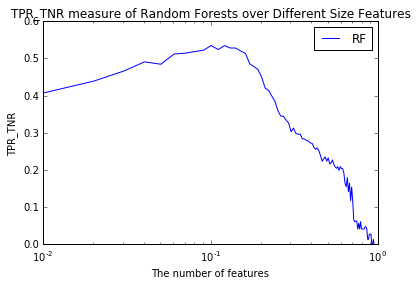

In [533]:
fig, ax = plt.subplots()

ax.set_ylabel('TPR_TNR')
ax.set_title('TPR_TNR measure of Random Forests over Different Size Features')

ax.plot(thresholds, accuracies_geo, label='RF', color='b')
ax.set_xlabel('The number of features')
ax.set_xscale('log')
_ = ax.legend(loc='upper right')

In [534]:
thresholds[np.argmax(accuracies_geo)]

0.10101010101010102

We use the top 100 impotrant features with threshold 0.1 for prediction.

# 3. Discussion

First, we consider the completion of missing data. Since the input dimension is large compared to the size of training set, we consider dimension reduction with random forests. The importance of feature of random forests is one of the quantities to measure how much each component contributes to the accuracy of prediction. We have shown that selected features based on this quantity works well not only on random forests itself but also other algorithms: neural network and linear regression. After comparing completion qualities, we decided to use the most 1000 important features with random forests.

At the prediction stage, we tried to work on dimension reduction in the same as completion. Features selected based on the importance of features, however, gave worse performance than the randomly selected ones. This comes from the skewed class distribution. Positive instances occupy only about 14% of entire training set. Therefore, we consider another metrics like AUC and geometric means of TPR and TNR. Finally we concluded to using the most 100 important features and threshold 0.1 for prediction.